In [1]:
import flax
import flax.linen as nn

import optax 

import jax
import jax.numpy as jnp

from model import SimpleRNN

from FlaxTrainer.trainer import TrainerModule
from FlaxTrainer.trainstates import TrainState

import transformers
from datasets import load_dataset_builder, load_dataset, get_dataset_split_names
import re


In [ ]:
get_dataset_split_names('imdb')

['train', 'test', 'unsupervised']

In [3]:
from typing import List


train_ds = load_dataset('imdb', split='train')
test_ds = load_dataset('imdb', split='test')

full_text = " ".join(train_ds['text'])

# full_text = re.sub("^[A-Za-z0-9_-]*$", '', full_text)
# full_text = full_text.replace('<br',"").replace('/>',"")
# vocabs = set(full_text.split(' '))
# vocabs = (list(vocabs))

# def tokenizing(vocab: List[str]):
#     id_to_text = {i:v for i, v in enumerate(vocab)}
#     text_to_id = {v:i for i, v in enumerate(vocab)}

#     return id_to_text, text_to_id

# id_to_text, text_to_id = tokenizing(vocabs)

In [4]:
import nltk

seperator = lambda x: nltk.regexp_tokenize(x, "\w+|\\?\!")

vocabs = list(set(seperator(full_text)))

def tokenizing(vocab: List[str]):
    id_to_text = {i:v for i, v in enumerate(vocab)}
    text_to_id = {v:i for i, v in enumerate(vocab)}

    return id_to_text, text_to_id

id_to_text, text_to_id = tokenizing(vocabs)

In [5]:
len(id_to_text)

93930

In [6]:
def scentence_tokenized(sent):
    word_seperation = seperator(sent)
    return [text_to_id[w] for w in word_seperation]

In [7]:
from typing import Any


class RnnClassifier(nn.Module):
    rng: Any
    embed_size: int
    embed_dim: int
    hidden_size: int

    @nn.compact
    def __call__(self, h, x, **kwargs):
        x = nn.Embed(self.embed_size, self.embed_dim)(x)
        o, h = SimpleRNN(20, 2)(x, h)

        return o, h
    @staticmethod
    def initialize_carry(
        rng, 
        batch_dims, 
        size,
        init_fn=nn.initializers.zeros
    ):
        return SimpleRNN.initialize_carry(rng, batch_dims, size, init_fn)

In [8]:
rnnC = RnnClassifier(
    jax.random.PRNGKey(0),
    embed_size=len(text_to_id),
    embed_dim=20,
    hidden_size=10
)



In [9]:
h = RnnClassifier.initialize_carry(
    jax.random.PRNGKey(0),
    (1, ),
    20
)
x = jax.random.randint(
    jax.random.PRNGKey(0),
    (1,),
    minval=1, maxval=20
)
h

DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0.]], dtype=float32)

In [10]:
variables = rnnC.init(jax.random.PRNGKey(0), h, x)

In [11]:
jax.tree_map(lambda x: x.shape , variables)

FrozenDict({
    params: {
        Embed_0: {
            embedding: (93930, 20),
        },
        SimpleRNN_0: {
            hidden_state: {
                bias: (20,),
                kernel: (40, 20),
            },
            output: {
                bias: (2,),
                kernel: (40, 2),
            },
        },
    },
})

In [12]:
rnnC.apply(variables=variables, x=x, h=h)

(DeviceArray([[-0.02662284,  0.39234704]], dtype=float32),
 DeviceArray([[0.        , 0.        , 0.36096382, 0.10458659, 0.        ,
               0.        , 0.        , 0.        , 0.        , 0.        ,
               0.28245187, 0.18464863, 0.02286166, 0.04945395, 0.        ,
               0.00896228, 0.21438086, 0.        , 0.04968444, 0.        ]],            dtype=float32))

In [13]:
example = jnp.array(scentence_tokenized(train_ds['text'][0]))
example.shape

(297,)

In [14]:
h

DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
from time import time


t = time()
for x in example.reshape(-1, 1):
     o, h = rnnC.apply(variables, h, x)
print(o, h)

print(time() - t)

[[ 0.101531   -0.03670267]] [[0.         0.33540764 0.27758348 0.         0.27738208 0.
  0.         0.03469883 0.59443516 0.11394904 0.         0.26410994
  0.2550305  0.         0.         0.21341687 0.10182323 0.
  0.14639407 0.        ]]
13.508159160614014


In [16]:
class RnnTrainState(TrainState):
    hidden_fn: Any=None


class RnnTrainer(TrainerModule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def init_model(
        self, model: nn.Module, 
        exmp_input: Any, 
        tabulated: bool = True):
        state =  super().init_model(model, exmp_input, tabulated)
        st_dict = state.__dict__
        
        state = RnnTrainState(
            **{
                **st_dict, "hidden_fn":model.init_state()
            }
        )
        return state
    
        
    def create_functions(self):
        def cross_entropy_loss(params, apply_fn, batch):
            x, y = batch
            y = jax.nn.one_hot(y, num_classes=10)
            logit = apply_fn({'params':params}, x)
            loss = optax.softmax_cross_entropy(logits=logit , labels=y).mean()
            return loss
    
        def train_step(state, batch):
            loss_fn = lambda params: cross_entropy_loss(params, state.apply_fn, batch)
            for word in 
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = cross_entropy_loss(state.params, state.apply_fn, batch)
            return {'loss': loss}

        return train_step, eval_step


SyntaxError: invalid syntax (2885781288.py, line 34)

In [16]:

def fn(i, ho):
    x = example.reshape(-1, 1)[i]
    h = ho[0]
    o, h = rnnC.apply(variables=variables, x=x, h=h)
    return [h, o]
    

In [17]:
h = RnnClassifier.initialize_carry(
    jax.random.PRNGKey(0),
    (1, ),
    20
)

ho = [h, jnp.zeros((1,2))]
fn(1, ho)

[DeviceArray([[0.00241531, 0.51561534, 0.3784473 , 0.        , 0.24155109,
               0.        , 0.02114906, 0.0136361 , 0.21647874, 0.00569096,
               0.        , 0.0266905 , 0.1747001 , 0.08343177, 0.19916058,
               0.20462283, 0.        , 0.16992225, 0.        , 0.        ]],            dtype=float32),
 DeviceArray([[-0.13409576,  0.09588944]], dtype=float32)]

In [18]:
jax.lax.fori_loop(0, len(example), fn,ho)

[DeviceArray([[0.        , 0.33540764, 0.27758348, 0.        , 0.27738208,
               0.        , 0.        , 0.03469883, 0.59443516, 0.11394904,
               0.        , 0.26410994, 0.2550305 , 0.        , 0.        ,
               0.21341687, 0.10182323, 0.        , 0.14639407, 0.        ]],            dtype=float32),
 DeviceArray([[ 0.101531  , -0.03670267]], dtype=float32)]

In [19]:
l = jax.lax.map(lambda x: jnp.concatenate([h, x.reshape(1,1)], axis=-1), example)

In [20]:
def fn(h, x):
    h = h[...,:-1]
    x = x[0,...,-1].astype(jnp.int32).reshape(-1,)
    o, h = rnnC.apply(variables=variables, x=x, h=h)
    h_r = jnp.concatenate([h, jnp.zeros((1,1))], axis=-1)
    return h_r, (h_r, o)

In [21]:
fn(l[0], l[1])

(DeviceArray([[0.00241531, 0.51561534, 0.3784473 , 0.        , 0.24155109,
               0.        , 0.02114906, 0.0136361 , 0.21647874, 0.00569096,
               0.        , 0.0266905 , 0.1747001 , 0.08343177, 0.19916058,
               0.20462283, 0.        , 0.16992225, 0.        , 0.        ,
               0.        ]], dtype=float32),
 (DeviceArray([[0.00241531, 0.51561534, 0.3784473 , 0.        , 0.24155109,
                0.        , 0.02114906, 0.0136361 , 0.21647874, 0.00569096,
                0.        , 0.0266905 , 0.1747001 , 0.08343177, 0.19916058,
                0.20462283, 0.        , 0.16992225, 0.        , 0.        ,
                0.        ]], dtype=float32),
  DeviceArray([[-0.13409576,  0.09588944]], dtype=float32)))

In [23]:
_, out = jax.lax.scan(fn, jnp.concatenate([h, jnp.zeros((1,1))], axis=1), l)
    

In [307]:
len(out[1])

297

In [25]:
jax.config.values

{'jax_tracer_error_num_traceback_frames': 5,
 'jax_pprint_use_color': True,
 'jax_host_callback_inline': False,
 'jax_host_callback_max_queue_byte_size': 256000000,
 'jax_host_callback_outfeed': False,
 'jax_host_callback_ad_transforms': False,
 'jax2tf_associative_scan_reductions': False,
 'jax2tf_default_experimental_native_lowering': False,
 'jax_platforms': None,
 'jax_enable_checks': False,
 'jax_check_tracer_leaks': False,
 'jax_debug_nans': False,
 'jax_debug_infs': False,
 'jax_log_compiles': False,
 'jax_parallel_functions_output_gda': False,
 'jax_array': False,
 'jax_distributed_debug': False,
 'jax_enable_custom_prng': False,
 'jax_default_prng_impl': 'threefry2x32',
 'jax_enable_custom_vjp_by_custom_transpose': False,
 'jax_hlo_source_file_canonicalization_regex': None,
 'jax_default_dtype_bits': '64',
 'jax_numpy_dtype_promotion': 'standard',
 'jax_enable_x64': False,
 'jax_default_device': None,
 'jax_disable_jit': False,
 'jax_numpy_rank_promotion': 'allow',
 'jax_defau

Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([6, 1, 56])
tensor([[-3.0383, -2.9525, -2.8406, -2.7903, -2.7879, -2.8717, -2.9408, -2.9191,
         -2.8845, -2.9514, -2.8650, -2.7973, -2.9063, -2.9675, -2.9688, -2.8231,
         -2.8585, -2.9047]], grad_fn=<LogSoftmaxBackward0>)
('English', 4)
category= English / line= Gascoyne
category= Spanish / line= Abarca
category= Arabic / line= Guirguis
category= Korean / line= Yim
category= Dutch / line= Vliert
category= Portuguese / line= Ferro
category= Korean / line= Pak
category= Dutch / line= Oorschot
category= Russian / line= Lysyh
category= Italian / line= Battaglia
5000 5% (0m 4s) 2.8548 Thomas / Greek ✗ (French)
10000 10% (0m 9s) 2.33

/tmp/ipykernel_109484/1037457242.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_109484/1037457242.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


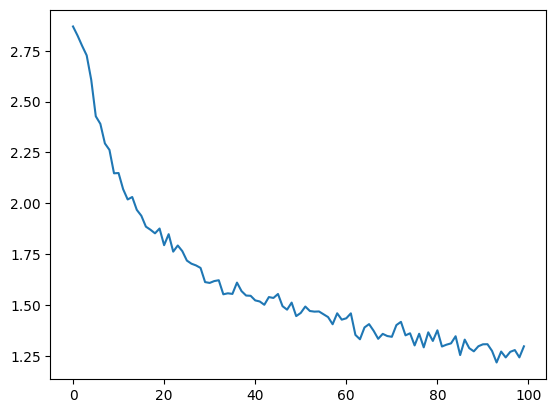

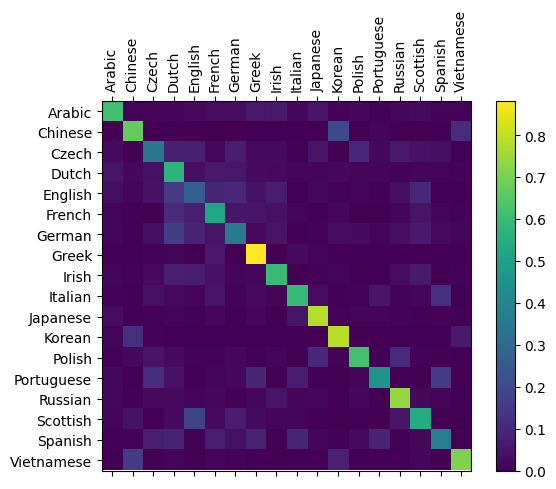


> Dovesky
(-0.71) Czech
(-0.84) Russian
(-3.54) English

> Jackson
(-0.98) English
(-1.30) Russian
(-1.69) Scottish

> Satoshi
(-1.07) Arabic
(-1.43) Japanese
(-2.16) Italian


In [69]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os 

import io
from  zipfile import ZipFile
from urllib.request import urlopen

import torch.nn as nn
import torch

res = urlopen('https://download.pytorch.org/tutorial/data.zip')
z = io.BytesIO(res.read())
z = ZipFile(z)
file_names = z.namelist()[3:]

import unicodedata
import string 
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = z.open(filename).readlines()
    lines = [str(l).replace("\\n'","").replace("b'", "") for l in lines]
    return [unicodeToAscii(line) for line in lines]

for filename in file_names:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

n_categories

print(category_lines['Italian'][:5])

import torch
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Johnes').size())



class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
            
        self.hidden_size = hidden_size
            
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
            
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
        
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

import random 


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category=', category, '/ line=', line)


                                   

criterion = nn.NLLLoss()

learning_rate = 0.005
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

    
    

import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()

plt.plot(all_losses) ;

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10_000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

In [71]:
import flax
import flax.linen as nn
from jax import random

class SimpleScan(nn.Module):
  @nn.compact
  def __call__(self, c, xs):
    LSTM = nn.scan(nn.LSTMCell,
                   variable_broadcast="params",
                   split_rngs={"params": False},
                   in_axes=1,
                   out_axes=1)
    return LSTM()(c, xs)

seq_len, batch_size, in_feat, out_feat = 20, 16, 3, 5
key_1, key_2, key_3 = random.split(random.PRNGKey(0), 3)

xs = random.uniform(key_1, (batch_size, seq_len, in_feat))
init_carry = nn.LSTMCell.initialize_carry(key_2, (batch_size,), out_feat)

model = SimpleScan()
variables = model.init(key_3, init_carry, xs)
out_carry, out_val = model.apply(variables, init_carry, xs)

assert out_val.shape == (batch_size, seq_len, out_feat)

In [72]:
out_val

DeviceArray([[[-0.1853381 , -0.10100141,  0.080236  ,  0.01992463,
               -0.06103022],
              [-0.01071439, -0.17999715,  0.03315278, -0.05530818,
                0.043177  ],
              [-0.04797849, -0.20263912,  0.09698375, -0.0426482 ,
                0.01547858],
              ...,
              [ 0.04662287, -0.19942182,  0.09726959, -0.04846162,
                0.09371966],
              [-0.13400127, -0.13887858,  0.10648201,  0.065263  ,
               -0.01726308],
              [-0.20786555, -0.10800423,  0.13088283,  0.08920371,
               -0.13810161]],

             [[-0.00163105, -0.07661658, -0.03404366, -0.02381711,
                0.04745721],
              [-0.02372325, -0.06632124, -0.00354327,  0.02185179,
                0.03569559],
              [-0.11647416, -0.13251291,  0.04258443,  0.0330095 ,
                0.00190553],
              ...,
              [-0.05010752, -0.1953249 ,  0.04155926,  0.01165552,
                0.05023681],
